In [7]:
# Basic Moving Average Crossover Trading Strategy
# 
# In this module we fetch historical stock data for Apple (AAPL) using the Polygon API,
# compute two simple moving averages (SMA), generate buy/sell signals based
# on crossovers, perform a simple backtest, and plot the results.
#
# Requirements:
# - Python 3
# - Libraries: polygon, pandas, numpy, matplotlib
# - Polygon API key: Sign up at polygon.io for a free API key and replace below.
#
# Example to backtesting, in real trading scenarios, we consider transaction costs, slippage & risk management.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polygon.rest import RESTClient
from datetime import datetime, timedelta

In [9]:
# Replacing with your Polygon API key
from config import API_KEY
# Initialize Polygon client
client = RESTClient(api_key=API_KEY)

In [10]:
# Parameters
ticker = "AAPL"  # Stock ticker
start_date = (datetime.now() - timedelta(days=365)).strftime("%Y-%m-%d") # Last 1 year
end_date = datetime.now().strftime("%Y-%m-%d")
short_window = 50 # Short SMA period, 50 days
long_window = 200


In [11]:
#Fetching historical daily data
aggs = client.get_aggs(ticker, 1, "day", start_date, end_date)
data = pd.DataFrame(aggs)
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)
data = data[['close']].rename(columns={'close': 'price'})

In [12]:
# Computing moving averages
data['short_sma'] = data['price'].rolling(window=short_window, min_periods=1).mean()
data['long_sma'] = data['price'].rolling(window=long_window, min_periods=1).mean()

In [13]:
# Generating signals: 1 for buy (short > long), -1 for sell (short < long), 0 otherwise
data['signal'] = 0
data['signal'][short_window:] = np.where(data['short_sma'][short_window:] > data['long_sma'][short_window:], 1, 0)
data['position'] = data['signal'].diff()  # Position changes on signal changes


/var/folders/_t/pq5rnry94s16k7dtqbwrj1nr0000gn/T/ipykernel_32232/409463446.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['signal'][short_window:] = np.where(data['short_sma'][short_window:] > data['long_sma'][short_window:], 1, 0)

In [14]:
# Simple backtest: Calculate returns (assuming we buy/sell 1 share)
data['returns'] = data['price'].pct_change()
data['strategy_returns'] = data['position'].shift(1) * data['returns']  # Lag position
data['cumulative_returns'] = (1 + data['strategy_returns']).cumprod() - 1

In [23]:
# Print summary
print(f"Total trades: {int(abs(data['position']).sum() / 2)}")  # Each buy/sell pair is a trade
print(f"Cumulative return: {data['cumulative_returns'].iloc[-1]:.2%}")

Total trades: 1
Cumulative return: 2.92%


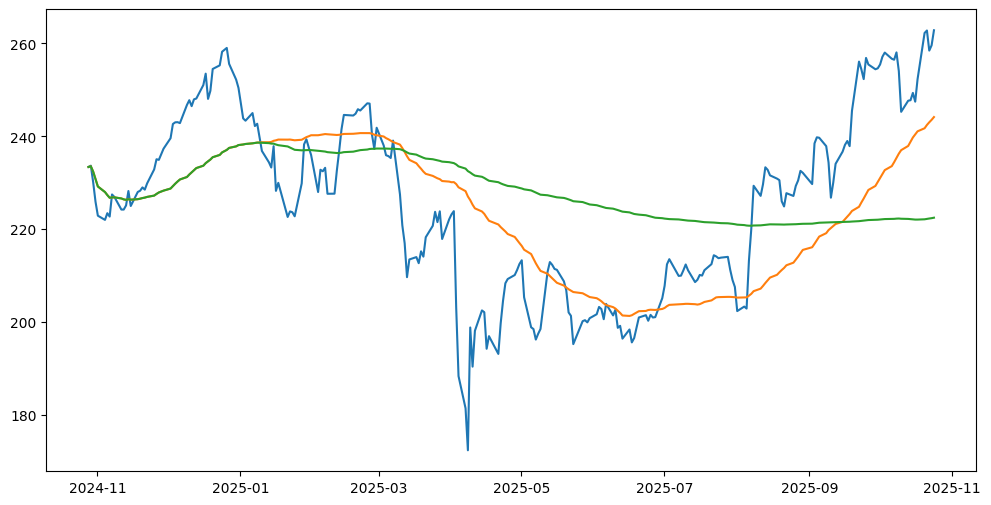

In [24]:
# Plot price, SMAs, and buy/sell signals
plt.figure(figsize=(12, 6))
plt.plot(data['price'], label='Price')
plt.plot(data['short_sma'], label=f'{short_window}-day SMA')
plt.plot(data['long_sma'], label=f'{long_window}-day SMA')


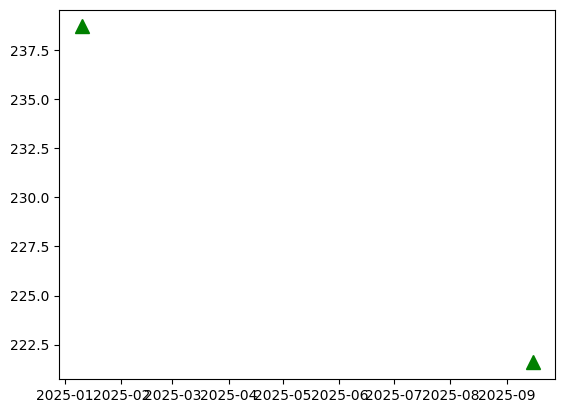

In [25]:
# Plot buy signals
plt.plot(data[data['position'] == 1].index, 
         data['short_sma'][data['position'] == 1], 
         '^', markersize=10, color='g', label='Buy Signal')

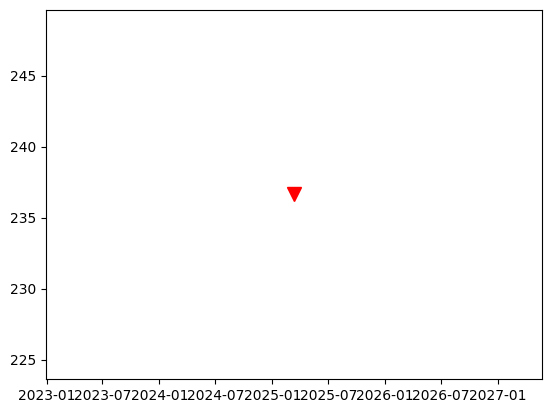

In [26]:
# Plot sell signals
plt.plot(data[data['position'] == -1].index, 
         data['short_sma'][data['position'] == -1], 
         'v', markersize=10, color='r', label='Sell Signal')

/var/folders/_t/pq5rnry94s16k7dtqbwrj1nr0000gn/T/ipykernel_39954/1832802069.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


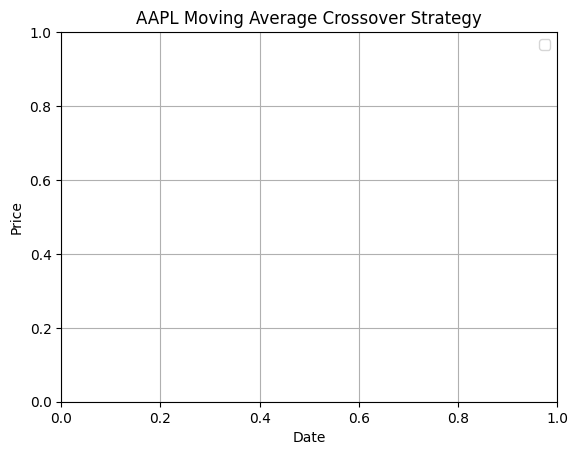

In [27]:
plt.title(f'{ticker} Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


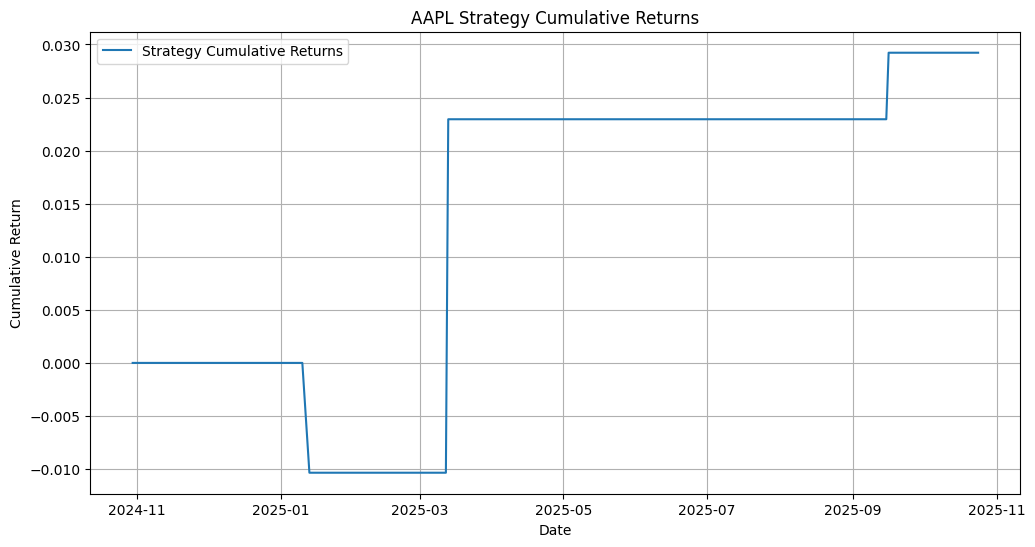

In [28]:
# Optional: Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(data['cumulative_returns'], label='Strategy Cumulative Returns')
plt.title(f'{ticker} Strategy Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()